CMPT 2400: Exploratory Data Analysis Data Project
Prepared by Laura Brin, Sandra Alex & Annabell Rodriguez

loading libraries

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
import calendar
from calendar import month_name as mn

# This makes it so we are able to see 100 rows when displaying the data
pd.set_option("display.max_rows", 100)

loading datasets

In [152]:
pass_df=pd.read_csv("dataset/International_Report_Passengers.csv")
depart_df=pd.read_csv("dataset/International_Report_Departures.csv")
world_airp_codes_df=pd.read_csv("dataset/world_airport_codes.csv")

### Posed Problem: Flight Delay Propagation Mitigation

International travel involves a web of interconnected airports in hundreds of countries every day of the year. 
The ripple effect caused by a cancelled or delayed flight can cause issues with missed connections, missing baggage, carrier fines, reimbursed customers and staffing issues.

According to the Federal Aviation Administration, Delay Propagation occurs when three conditions are met simultaneously (https://aspm.faa.gov/aspmhelp/index/Delay_Propagation.html#:~:text=Delay%20propagation%20occurs%20when%20a,identified%20by%20a%20tail%20number.):

- A flight arrives late at an airport.
- A flight departs late in subsequent stages.
- A flight arrives late at the next destination.


### Posed Solution

We would like to pitch a ML solution using this dataset that would assist with real time decisions for domestic flight delays. When domestic flight centers experience multiple delays, air traffic decision makers can use the model to help predict which flights should be prioritized for take-off to reduce flight delay propagation into international connecting flights. It will do this by looking at the relationship between the flight's intended landing airport, the number of international airports that site connects with, how many flights leave that site, the region of the airport and the time of year.

### Observing Departures Dataset

This dataset contains data on all the flights between US gateways and non-US gateways. It is a record of international flights departing US and can be used to highlight busiest airports, and peak times for flight volume

There are multiple abbreviations used in this section:
* DOT: Department of Transportation
* FAA: Federal Aviation Administration
* IATA: International Air Transportation Association
* ICAO: International Civil Aviation Organization

    #Laura

#### Features

Date- in MM/DD/YYYY format

Year

Month

> usg_apt_id: US Gateway Airport ID- assigned by US DOT to identify airport

> usg_apt: US Gateway Airport Code- usually assigned by IATA but in absence of IATA designation, may show FAA-assigned code. For full list of World Airport codes see the Bureau of Transportation Statistics: https://www.bts.gov/topics/airlines-and-airports/world-airport-codes 

        These two features are related. They represent the numerical location code (US) and three letter code for location identification, respectively. These should correlate 1:1 except where FAA coding was used in the absence of IATA coding. 


usg_wac: US Gateway World Area code- assigned by US DOT to represent a geographic territory. 
* 1-99 USA, 
* 100-199 Central America, 
* 200-299 Caribbean, Bahamas and Bermuda, 
* 300-399 South America, 
* 400-499 Europe, 
* 500-599 Africa, 
* 600-699 Middle East, 
* 700-800 Far East/Asia, 
* 801-899 Antarctica, Australasia and Oceania, 
* 900-999 Canada and Greenland 
codes groupings from https://en.wikipedia.org/wiki/World_Area_Codes



> fg_apt_id: Foreign Gateway Airport ID-assigned by US DOT to identify an airport

> fg_apt: Foreign Gateway Airport Code- usually assigned by IATA but in absence of IATA designation, may show FAA assigned code

> fg_wac: Foreign Gateway World Area Code- Assigned by US DOT to represent territory. For code groups see above in usg_wac comments

        These three features are related. They represent the five digit numerical location code (US), three letter code for location identification (International), and three digit numerical location code (international), respectively.

> airlineid: Airline ID assigned by US DOT to identify an air carrier

> carrier: IATA assigned air carrier code. If carrier has no IATA code, ICAO- or FAA assigned code may be used. These are mixed letter/number codes. For full list of air carrier codes see the Bureau of Transportation Statistics: https://www.bts.gov/topics/airlines-and-airports/airline-codes 

        These two features are related. They represent the five digit numerical airline ID (US) and the two or three character air carrier id (international). These should correlate 1:1 except where IATA coding was absent. 

carriergroup: group code. 1=US domestic air carriers, 0=foreign air carriers

type: type of the metrics- this is a single code for this dataset= "Departures"

> Scheduled: metric flow by scheduled service operations. Scheduled flights are those commercially available for indivdual purchase

> Charter: metric flown by charter operations. Charter flights are booked by a group or consortium responsible for all seats on the flight. This is commonly reffered to as private flights

        These two features are related. Flights are listed as either scheduled or charter. Flights on the same day, from the same airline id, with the same take off and landing sites are recorded as a count metric

Total: scheduled+charter flight counts



        Notes: 
need to set date format correctly
year/month-numerical-any need for month to be in categorical?
need to check where more than 2 usg_apt is assigned to usg_apt_id and relabel
important pieces- US gatewayForeign Gateway and US_ world Area codeforeign world area code
year,month,
apt_ids and airlineid all as numeric-actually categorical
should discuss if we want to include charter flights as the problem statement is directed towards scheduled flights

In [153]:
depart_df.head(20)

,data_dte,Year,Month,usg_apt_id,usg_apt,usg_wac,fg_apt_id,fg_apt,fg_wac,airlineid,carrier,carriergroup,type,Scheduled,Charter,Total
0,05/01/2006,2006,5,12016,GUM,5,13162,MAJ,844,20177,PFQ,1,Departures,0,10,10
1,05/01/2003,2003,5,10299,ANC,1,13856,OKO,736,20007,5Y,1,Departures,0,15,15
2,03/01/2007,2007,3,10721,BOS,13,12651,KEF,439,20402,GL,1,Departures,0,1,1
3,12/01/2004,2004,12,11259,DAL,74,16271,YYZ,936,20201,AMQ,1,Departures,0,1,1
4,05/01/2009,2009,5,13303,MIA,33,11075,CMW,219,21323,5L,0,Departures,0,20,20
5,10/01/2007,2007,10,14761,SFB,33,11928,GLA,493,20444,JN,0,Departures,0,8,8
6,02/01/2002,2002,2,14100,PHL,23,11032,CUN,148,20402,MMQ,1,Departures,0,1,1
7,02/01/2008,2008,2,16091,YIP,43,16166,YQG,936,20201,AMQ,1,Departures,0,3,3
8,11/01/2001,2001,11,13930,ORD,41,16042,YEG,916,19531,AC,0,Departures,0,1,1
9,07/01/2003,2003,7,13198,MCI,64,13514,MTY,148,20201,AMQ,1,Departures,0,1,1


In [154]:
depart_df.describe()

,Year,Month,usg_apt_id,usg_wac,fg_apt_id,fg_wac,airlineid,carriergroup,Scheduled,Charter,Total
count,930808.000000,930808.000000,930808.000000,930808.000000,930808.000000,930808.000000,930808.000000,930808.000000,930808.000000,930808.000000,930808.000000
mean,2006.021361,6.414783,12809.473781,42.511740,13484.676238,466.910479,20057.217505,0.599361,40.003181,2.005483,42.008665
std,8.558831,3.471070,2716.223845,27.571338,1932.601107,288.005971,479.071456,0.490028,60.948973,8.278403,60.340835
min,1990.000000,1.000000,10010.000000,1.000000,10119.000000,106.000000,19386.000000,0.000000,0.000000,0.000000,1.000000
25%,1999.000000,3.000000,11618.000000,22.000000,11868.000000,205.000000,19704.000000,0.000000,0.000000,0.000000,3.000000
50%,2007.000000,6.000000,12892.000000,33.000000,13408.000000,427.000000,19991.000000,1.000000,17.000000,0.000000,20.000000
75%,2014.000000,9.000000,13487.000000,72.000000,15084.000000,736.000000,20312.000000,1.000000,60.000000,1.000000,60.000000
max,2020.000000,12.000000,99999.000000,93.000000,16881.000000,975.000000,22067.000000,1.000000,2019.000000,1092.000000,2019.000000


In [155]:
depart_df.shape

(930808, 16)

In [156]:
depart_df.dtypes

data_dte        object
Year             int64
Month            int64
usg_apt_id       int64
usg_apt         object
usg_wac          int64
fg_apt_id        int64
fg_apt          object
fg_wac           int64
airlineid        int64
carrier         object
carriergroup     int64
type            object
Scheduled        int64
Charter          int64
Total            int64
dtype: object

### Annabell

#### Correting data types

In [157]:
# Change datatype of the date column
### departures
depart_df["data_dte"] = pd.to_datetime(depart_df["data_dte"])
### passengers
pass_df["data_dte"] = pd.to_datetime(pass_df["data_dte"])

# Change datatype of the categories columns
world_airp_code_type = pd.CategoricalDtype(categories=world_airp_codes_df['Code'].unique())
departure_type_type = pd.CategoricalDtype(categories=["Departures", "Passengers"])

### departures
depart_df['usg_apt'] = depart_df['usg_apt'].astype(world_airp_code_type)
depart_df['fg_apt'] = depart_df['fg_apt'].astype(world_airp_code_type)
depart_df['carrier'] = depart_df['carrier'].astype(world_airp_code_type)
depart_df['type'] = depart_df['carrier'].astype(departure_type_type)

### passengers
pass_df['usg_apt'] = pass_df['usg_apt'].astype(world_airp_code_type)
pass_df['fg_apt'] = pass_df['fg_apt'].astype(world_airp_code_type)
pass_df['carrier'] = pass_df['carrier'].astype(world_airp_code_type)
pass_df['type'] = pass_df['carrier'].astype(departure_type_type)


In [158]:
### departures
depart_df.dtypes

data_dte        datetime64[ns]
Year                     int64
Month                    int64
usg_apt_id               int64
usg_apt               category
usg_wac                  int64
fg_apt_id                int64
fg_apt                category
fg_wac                   int64
airlineid                int64
carrier               category
carriergroup             int64
type                  category
Scheduled                int64
Charter                  int64
Total                    int64
dtype: object

In [159]:
### passengers
pass_df.dtypes

data_dte        datetime64[ns]
Year                     int64
Month                    int64
usg_apt_id               int64
usg_apt               category
usg_wac                  int64
fg_apt_id                int64
fg_apt                category
fg_wac                   int64
airlineid                int64
carrier               category
carriergroup             int64
type                  category
Scheduled                int64
Charter                  int64
Total                    int64
dtype: object

Observing the correlation between the columns

In [160]:
### departures
df_c = depart_df.corr(numeric_only=True)
df_c

,Year,Month,usg_apt_id,usg_wac,fg_apt_id,fg_wac,airlineid,carriergroup,Scheduled,Charter,Total
Year,1.000000,-0.021233,0.005048,0.065969,0.053412,0.045974,0.312519,0.022367,0.069213,-0.052756,0.062673
Month,-0.021233,1.000000,-0.000944,-0.001765,-0.000760,0.017482,-0.004098,-0.007390,0.013036,-0.007488,0.012140
usg_apt_id,0.005048,-0.000944,1.000000,0.069199,0.030126,-0.002550,0.050586,-0.008993,-0.022789,0.000585,-0.022939
usg_wac,0.065969,-0.001765,0.069199,1.000000,0.096134,-0.043867,-0.004251,-0.050752,0.041788,-0.024382,0.038864
fg_apt_id,0.053412,-0.000760,0.030126,0.096134,1.000000,0.505629,0.076175,-0.002074,0.082709,-0.027337,0.079792
fg_wac,0.045974,0.017482,-0.002550,-0.043867,0.505629,1.000000,-0.002809,-0.148620,0.109073,-0.039502,0.104752
airlineid,0.312519,-0.004098,0.050586,-0.004251,0.076175,-0.002809,1.000000,0.116642,-0.144813,0.081447,-0.135098
carriergroup,0.022367,-0.007390,-0.008993,-0.050752,-0.002074,-0.148620,0.116642,1.000000,-0.026875,0.040866,-0.021539
Scheduled,0.069213,0.013036,-0.022789,0.041788,0.082709,0.109073,-0.144813,-0.026875,1.000000,-0.141007,0.990733
Charter,-0.052756,-0.007488,0.000585,-0.024382,-0.027337,-0.039502,0.081447,0.040866,-0.141007,1.000000,-0.005234


In [161]:
### passengers
pdf_c = pass_df.corr(numeric_only=True)
pdf_c

,Year,Month,usg_apt_id,usg_wac,fg_apt_id,fg_wac,airlineid,carriergroup,Scheduled,Charter,Total
Year,1.000000,-0.016399,0.007141,0.052941,0.051617,0.036911,0.331199,0.035147,0.101612,-0.129603,0.088185
Month,-0.016399,1.000000,-0.000288,0.000012,-0.001978,0.021702,-0.006513,-0.014229,0.033731,-0.016936,0.032193
usg_apt_id,0.007141,-0.000288,1.000000,0.075745,0.035645,0.025577,0.048309,-0.038074,-0.021915,0.010481,-0.020974
usg_wac,0.052941,0.000012,0.075745,1.000000,0.089745,-0.031150,-0.016639,-0.036533,0.034814,-0.020994,0.032833
fg_apt_id,0.051617,-0.001978,0.035645,0.089745,1.000000,0.534591,0.085683,-0.028446,-0.086146,-0.051050,-0.092770
fg_wac,0.036911,0.021702,0.025577,-0.031150,0.534591,1.000000,0.012183,-0.193238,0.085149,-0.061695,0.079146
airlineid,0.331199,-0.006513,0.048309,-0.016639,0.085683,0.012183,1.000000,0.079921,-0.235533,0.045278,-0.232959
carriergroup,0.035147,-0.014229,-0.038074,-0.036533,-0.028446,-0.193238,0.079921,1.000000,-0.073252,-0.008559,-0.074985
Scheduled,0.101612,0.033731,-0.021915,0.034814,-0.086146,0.085149,-0.235533,-0.073252,1.000000,-0.149451,0.993860
Charter,-0.129603,-0.016936,0.010481,-0.020994,-0.051050,-0.061695,0.045278,-0.008559,-0.149451,1.000000,-0.039135


        We cannot appreciate an existing correlation between the numerical columns. The only association we can identify is between the scheduled column and the total column. Given that the total column displays the total of the scheduled and charter, this is to be expected. While it seems strange that there is no relationship between the charter and the sum. Let's look at the sum of these columns.

In [162]:
### departures
print(depart_df['Charter'].sum())
print(depart_df['Scheduled'].sum())

1866720
37235281


In [163]:
### passengers
print(pass_df['Charter'].sum())
print(pass_df['Scheduled'].sum())

133977185
4412029495


        We can observe a significant disparity between them based on these totals. Since charter flights are less frequent, their occurrence has little impact on the total.

##### Analyzing seasonal patterns

Grouping the totals by date and analyzing them in time. The column data_dte represents a month because the day is always 01.

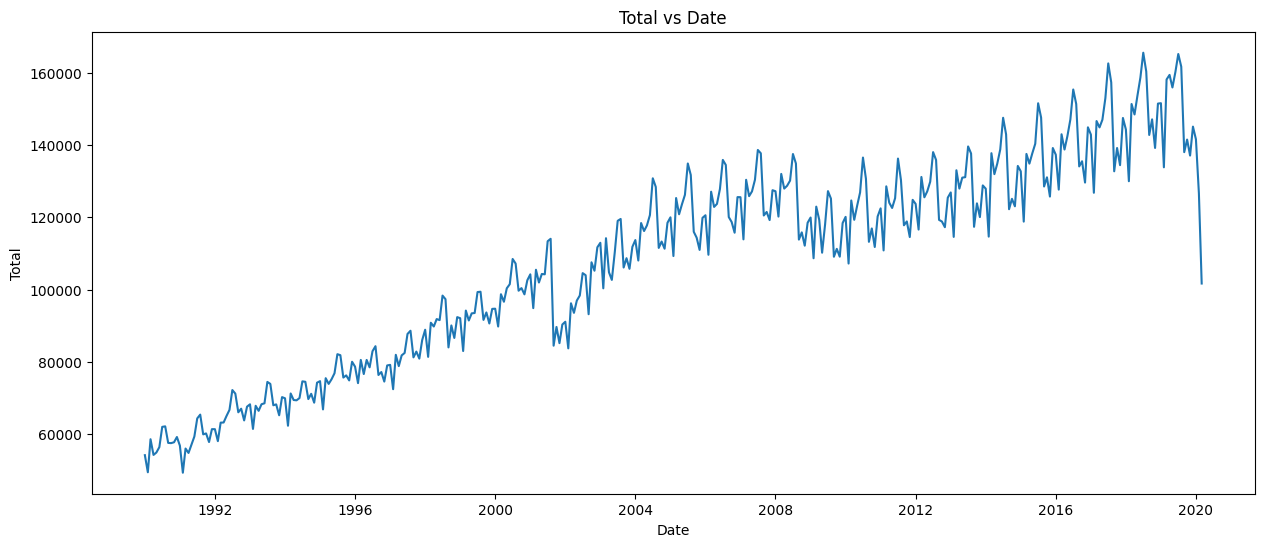

In [164]:
### departures
plt.figure(figsize=(15,6))
out_total = depart_df.groupby('data_dte')['Total'].sum().reset_index(name ='Total')
sns.lineplot(x='data_dte',y='Total',data=out_total)
plt.title("Total vs Date")
plt.xlabel("Date")
plt.ylabel("Total")
plt.show()

In [165]:
### departures
out_total.describe()

,Total
count,363.000000
mean,107719.011019
std,28361.417789
min,49264.000000
25%,82633.000000
50%,113395.000000
75%,128677.000000
max,165616.000000


Analyzing Charter vs Scheduled

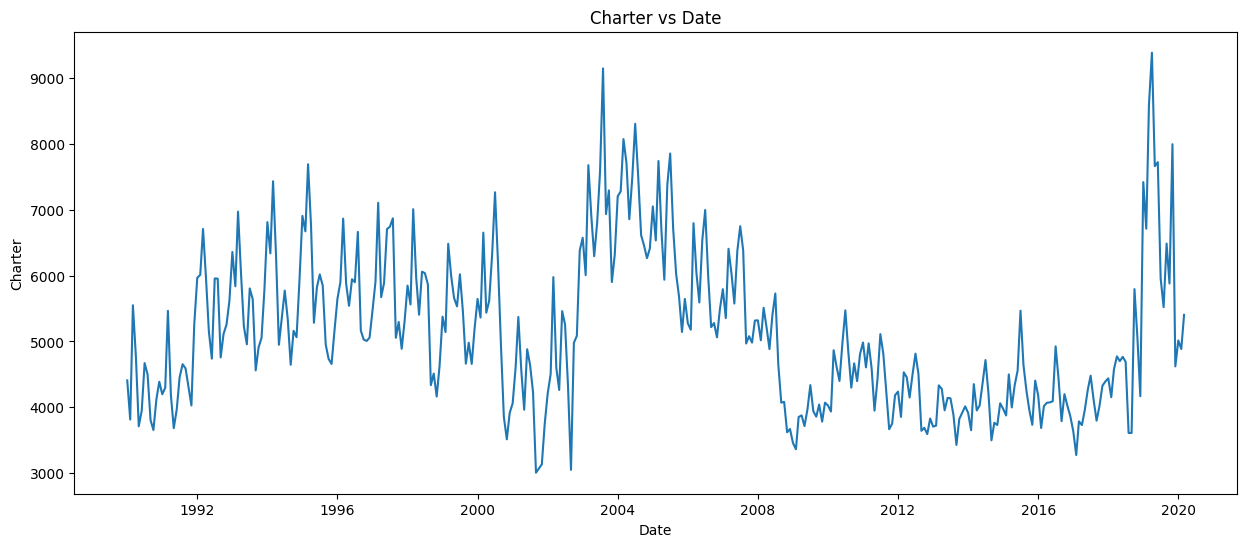

In [166]:
### departures
plt.figure(figsize=(15,6))
out_charter = depart_df.groupby('data_dte')['Charter'].sum().reset_index(name ='Charter')
sns.lineplot(x='data_dte',y='Charter',data=out_charter)
plt.title("Charter vs Date")
plt.xlabel("Date")
plt.ylabel("Charter")
plt.show()


In [167]:
### departures
out_charter.describe()

,Charter
count,363.000000
mean,5142.479339
std,1176.059697
min,3007.000000
25%,4184.000000
50%,4978.000000
75%,5905.500000
max,9382.000000


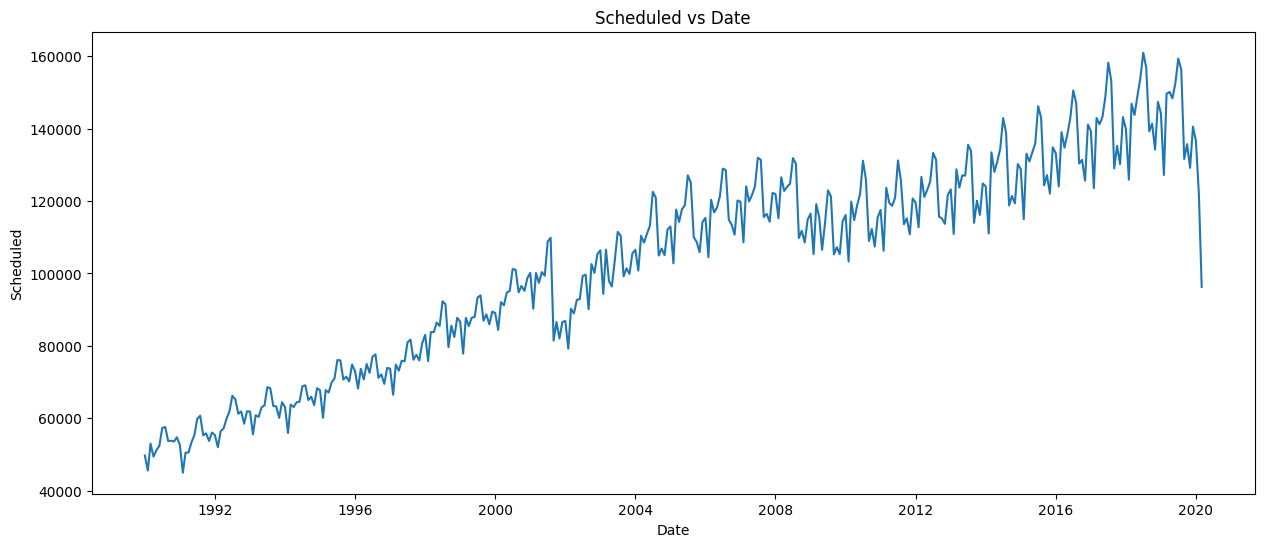

In [168]:
### departures
plt.figure(figsize=(15,6))
out_scheduled = depart_df.groupby('data_dte')['Scheduled'].sum().reset_index(name ='Scheduled')
sns.lineplot(x='data_dte',y='Scheduled',data=out_scheduled)
plt.title("Scheduled vs Date")
plt.xlabel("Date")
plt.ylabel("Scheduled")
plt.show()

In [169]:
### departures
out_scheduled.describe()

,Scheduled
count,363.000000
mean,102576.531680
std,28467.779514
min,44968.000000
25%,76593.000000
50%,108506.000000
75%,124008.000000
max,160926.000000


        We must evaluate charter departures separately since, as we have already seen, they are less frequent than scheduled departures. The graphics demonstrate how this situation causes the entire curve to be almost equivalent to the scheduled one.

        We are unable to identify a growth pattern in the chart of charter departures. Between 1990 and 1996, it grew; following that, it was relatively constant with some pikes until 2010, when it suddenly decreased. It then recovered, peaking in value in 2004, after which a steady drop started. This pattern can be traced back to 2010, when it suddenly increased at the beginning of 2020, reaching its greatest level since 1990, before beginning to drop in the months that followed. The maximum was 9382, and the mean was about 5142. We can see some seasonality there; eventually, we'll look into it more thoroughly.

        On the graph of the scheduled departures, there is a clear seasonality and an upward trend. Between 2000 to 2004, there was a decline, which swiftly recovered. In 2020, we started to notice the start of the pandemic's effects. Sadly, there are just a few months of this year in the dataset.


##### Looking to the passengers dataframe

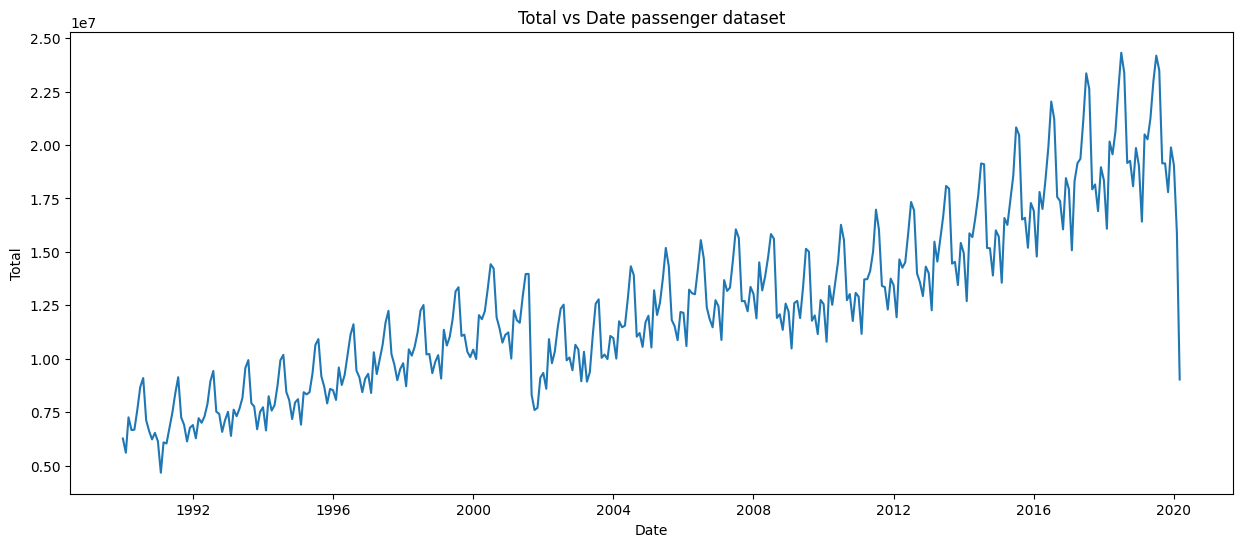

In [170]:
### passengers
plt.figure(figsize=(15,6))
out_total = pass_df.groupby('data_dte')['Total'].sum().reset_index(name ='Total')
sns.lineplot(x='data_dte',y='Total',data=out_total)
plt.title("Total vs Date passenger dataset")
plt.xlabel("Date")
plt.ylabel("Total")
plt.show()

In [171]:
### passengers
out_total.describe()

,Total
count,3.630000e+02
mean,1.252343e+07
std,4.029453e+06
min,4.672216e+06
25%,9.459132e+06
50%,1.204304e+07
75%,1.497831e+07
max,2.431484e+07


Analyzing Charter vs Scheduled

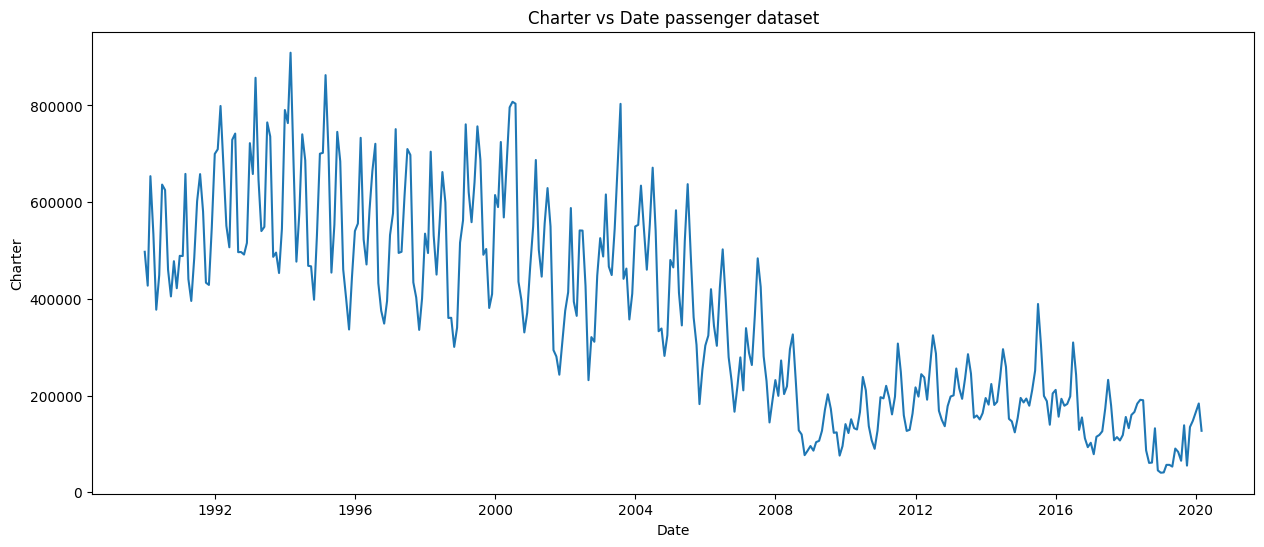

In [172]:
### passengers
plt.figure(figsize=(15,6))
out_charter = pass_df.groupby('data_dte')['Charter'].sum().reset_index(name ='Charter')
sns.lineplot(x='data_dte',y='Charter',data=out_charter)
plt.title("Charter vs Date passenger dataset")
plt.xlabel("Date")
plt.ylabel("Charter")
plt.show()

In [173]:
### passengers
out_charter.describe()

,Charter
count,363.000000
mean,369083.154270
std,209028.711052
min,40644.000000
25%,183684.000000
50%,344375.000000
75%,533134.500000
max,909107.000000


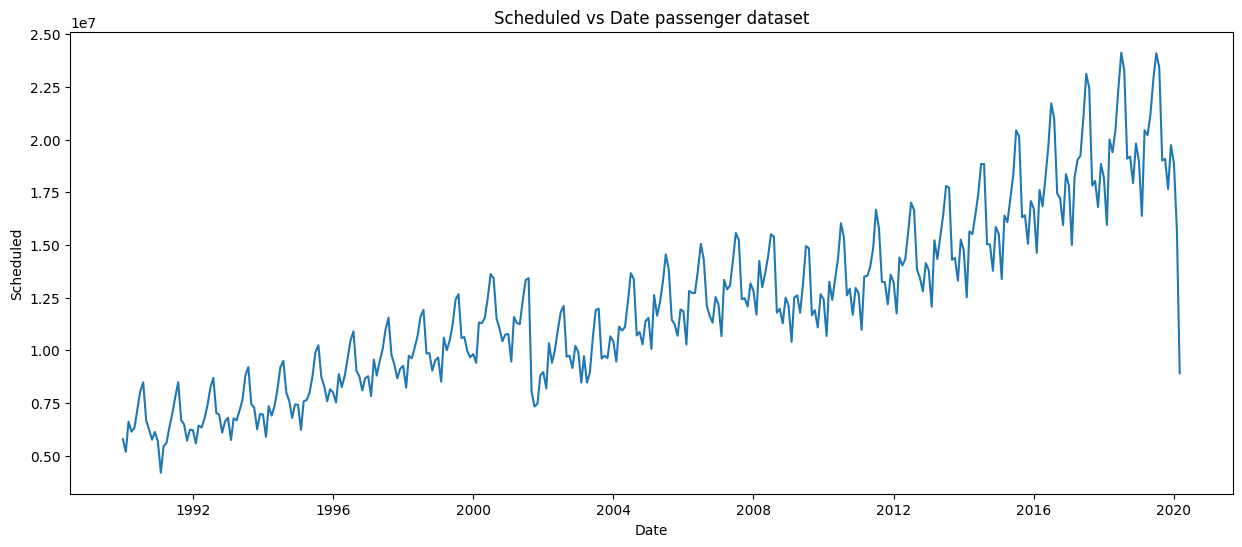

In [174]:
### passengers
plt.figure(figsize=(15,6))
out_scheduled = pass_df.groupby('data_dte')['Scheduled'].sum().reset_index(name ='Scheduled')
sns.lineplot(x='data_dte',y='Scheduled',data=out_scheduled)
plt.title("Scheduled vs Date passenger dataset")
plt.xlabel("Date")
plt.ylabel("Scheduled")
plt.show()

In [175]:
### passengers
out_scheduled.describe()

,Scheduled
count,3.630000e+02
mean,1.215435e+07
std,4.158586e+06
min,4.183535e+06
25%,8.992807e+06
50%,1.167780e+07
75%,1.468768e+07
max,2.412434e+07


        The graphs show how comparable the patterns in the passenger dataset are to those in the departure dataset.

        In the case of charters, there is a propensity for this to decrease over time. With a little gain in the early years, roughly from 1990 to 1994, it then starts to decline. Some seasonality exists.

        However, the trend is upward for those that are scheduled. The reduction between 2000 and 2004 is also visible, but it subsequently resumed its upward trend until 2020, when it abruptly fell, as we now know due to the pandemic. There is a visible seasonality.

##### Analizing the last five years

In [176]:
# month list
months = mn[1:]

### departures
max_year_depart = depart_df["Year"].max()
### passengers
max_year_pass = pass_df["Year"].max()

### departures
depart_df['month_category'] = depart_df['Month'].apply(lambda x: calendar.month_name[x])

### passengers
pass_df['month_category'] = pass_df['Month'].apply(lambda x: calendar.month_name[x])

# convert the column to categorical and ordered
### departures
depart_df["month_category"] = pd.Categorical(depart_df["month_category"], categories=months, ordered=True)
### passengers
pass_df["month_category"] = pd.Categorical(pass_df["month_category"], categories=months, ordered=True)

### departures
depart_df_last_5_years = depart_df.loc[(depart_df['Year'] >= (max_year_depart-4)) & (depart_df['Year'] <= max_year_depart)]
### passengers
pass_df_last_5_years = pass_df.loc[(pass_df['Year'] >= (max_year_pass-4)) & (pass_df['Year'] <= max_year_pass)]

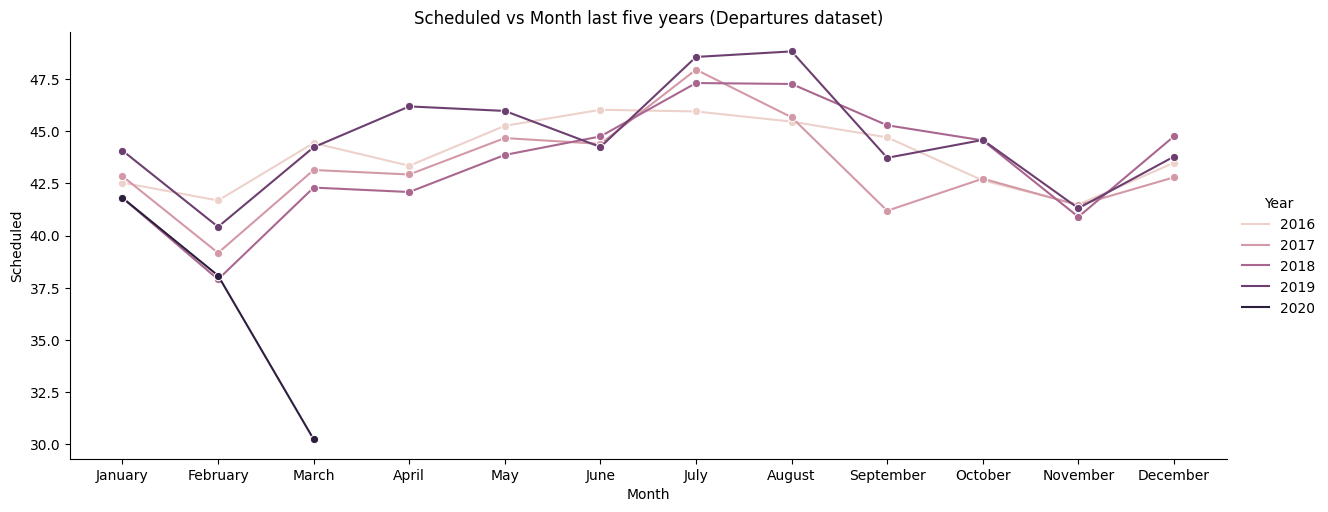

In [177]:
### departures
sns.relplot(kind='line', data=depart_df_last_5_years, x='month_category', y='Scheduled', hue='Year', aspect=2.5, marker='o', errorbar=None, height=5)
plt.title("Scheduled vs Month last five years (Departures dataset)")
plt.xlabel("Month")
plt.ylabel("Scheduled")
plt.show()

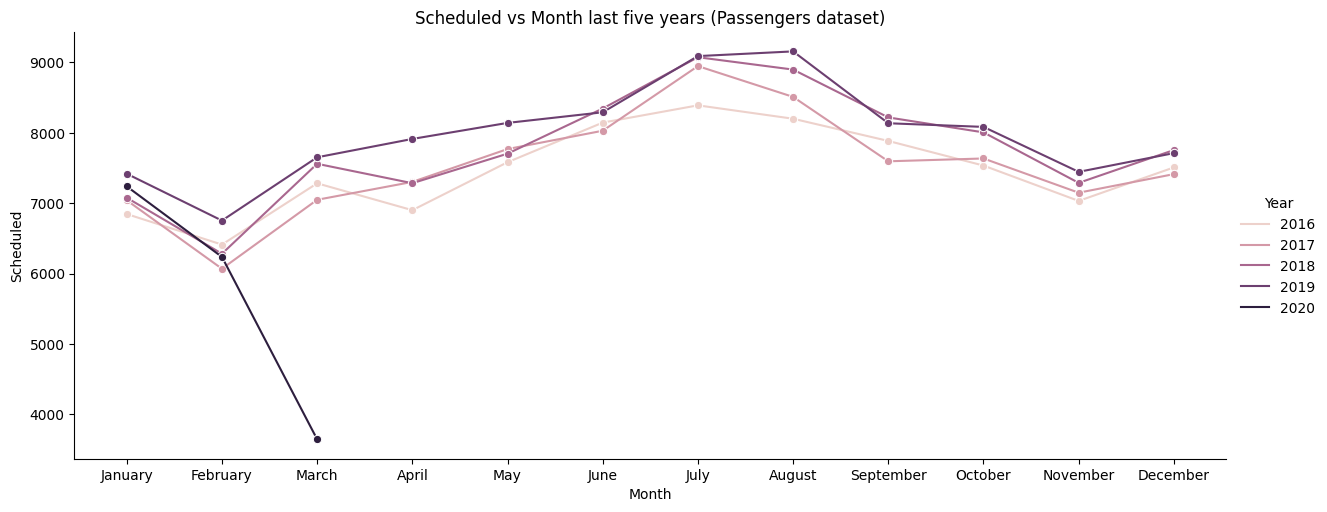

In [178]:
### passengers
sns.relplot(kind='line', data=pass_df_last_5_years, x='month_category', y='Scheduled', hue='Year', aspect=2.5, marker='o', errorbar=None, height=5)
plt.title("Scheduled vs Month last five years (Passengers dataset)")
plt.xlabel("Month")
plt.ylabel("Scheduled")
plt.show()


        We can see the seasonality in these two graphs. In the case of the scheduled flights, there are several similarities between the two datasets. The largest numbers are in July and August, while the lowest values are in February. After beginning in January about the middle, it drops in February, climbs in March, and diminishes in April . Then, beginning in May, the amount rises through August before falling in September, grows a little in October, drops off in November, then picks back up in December. Over the past five years, there has been a recurring pattern.

        2020 is the exception. Due to the pandemic, it should have increased in March but instead fell to its lowest level.

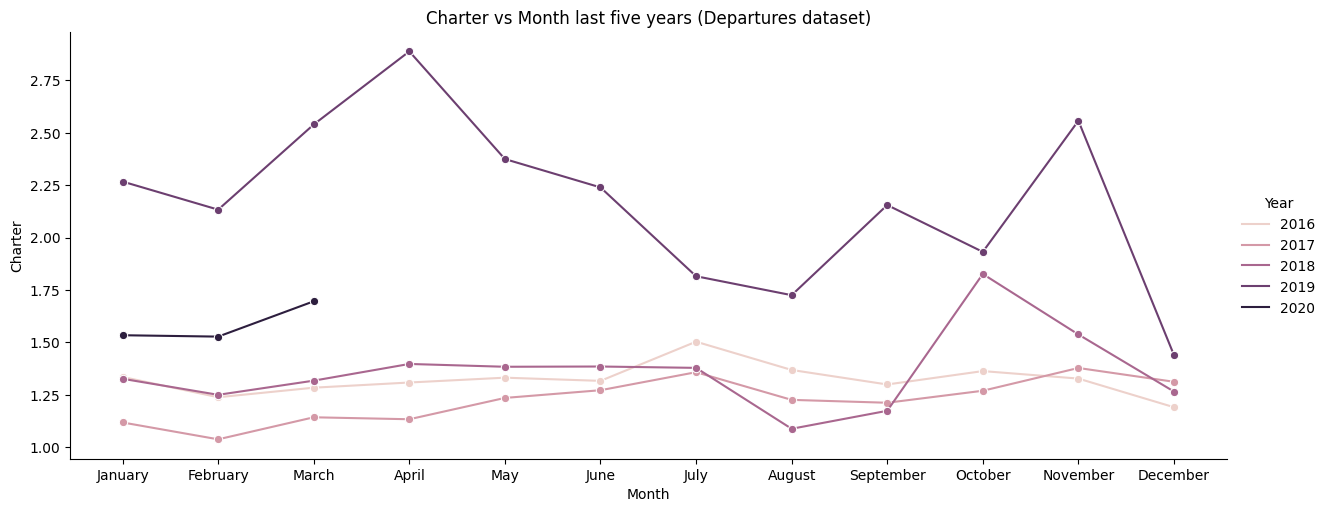

In [179]:
### departures
sns.relplot(kind='line', data=depart_df_last_5_years, x='month_category', y='Charter', hue='Year', aspect=2.5, marker='o', errorbar=None, height=5)
plt.title("Charter vs Month last five years (Departures dataset)")
plt.xlabel("Month")
plt.ylabel("Charter")
plt.show()

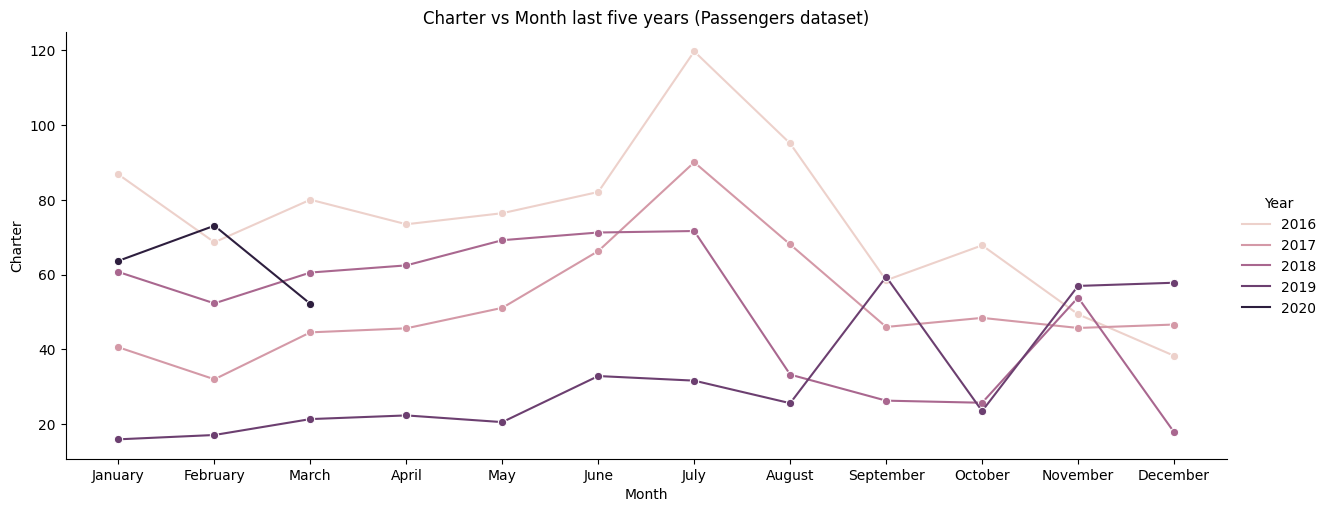

In [180]:
### passengers
sns.relplot(kind='line', data=pass_df_last_5_years, x='month_category', y='Charter', hue='Year', aspect=2.5, marker='o', errorbar=None, height=5)
plt.title("Charter vs Month last five years (Passengers dataset)")
plt.xlabel("Month")
plt.ylabel("Charter")
plt.show()

        It differs between the two datasets for charter flights.

        With the exception of October 2018, which grew significantly more than the rest of the years, the departures dataset's seasonality can be appreciated during the first three years of analysis. However, 2019 follows a different pattern, and the values rise much more dramatically. Up to March, the final month we have, it seems to start recovering the old pattern in 2020. The values here are lowest in the initial years.

        In contrast, the passenger dataset's beginning years had the highest numbers, and 2019 shows a fall. 2020 is out of the question because of the enormous behavioural change brought on by the epidemic.



### Sandra